In [148]:
import pandas as pd
import numpy as np

test_path = './data/df_test.csv'
train_path = './data/df_train.csv'

test_df = pd.read_csv(test_path)
train_df = pd.read_csv(train_path)


## Tarefas

1. Realize uma análise exploratória dos dados e responda às seguintes questões: 

    i. Existe alguma cidade com taxa de churn significativamente maior? 
    
    ii. O churn é mais prevalente entre clientes recentes ou antigos? Quais serviços são menos utilizados?

2. Compare os resultados obtidos entre uma árvore de decisão e uma floresta aleatória
em termos de precisão na classificação de churn de clientes. Avalie também outras
métricas relevantes, como recall e F1-score, para entender melhor a eficácia de cada
modelo na previsão de churn.

3. Demonstre o uso da validação cruzada para avaliar o desempenho de um modelo de
machine learning. Inclua uma descrição dos tipos comuns de validação cruzada e como
cada um pode ser aplicado para melhorar a generalização do modelo.

4. Como a aplicação de técnicas de redução de dimensionalidade, como PCA (Análise de
Componentes Principais), afeta o desempenho dos modelos de predição de churn?
A entrega é individual e deverá ser colocada no seu GitHub pessoal.

### 1.1 existe alguma cidade com taxa de churn significativamente maior? 

Análise city x churn

In [149]:
train_df['City'].unique()

array(['Los Angeles', 'Dulzura', 'San Jose', ..., 'Fawnskin', 'Leggett',
       'Korbel'], dtype=object)

In [150]:
train_df['City'].value_counts().head(20)

City
Los Angeles      270
San Diego        130
San Jose          94
San Francisco     91
Sacramento        90
Fresno            58
Long Beach        52
Oakland           39
Stockton          36
Glendale          34
Bakersfield       31
Riverside         30
Whittier          28
Modesto           25
Anaheim           24
Berkeley          24
Santa Barbara     24
Irvine            24
Pasadena          23
Burbank           23
Name: count, dtype: int64

Codificar valores de Yes e No em todas as colunas para facilitar a análise 

In [151]:
train_df = train_df.replace({'Yes': 1, 'No': 0})
train_df['Churn Label']

/tmp/ipykernel_405604/1272574614.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df = train_df.replace({'Yes': 1, 'No': 0})


0       0
1       0
2       0
3       0
4       1
       ..
5981    0
5982    0
5983    0
5984    0
5985    1
Name: Churn Label, Length: 5986, dtype: int64

A partir das cinco primeiras cidades com o maior numero de aparições as cidades começam a aparecer muito pouco nos dados, então foi decidido analisar as cinco primeiras cidades com maior numero de aparições e caluclar a taxa de churn em cima delas.

In [152]:

top_5_cities = train_df['City'].value_counts().head(5).index
filtered_df = train_df[train_df['City'].isin(top_5_cities)]
churn_rates = filtered_df.groupby('City')['Churn Label'].mean().sort_values(ascending=False)
print(churn_rates)

City
Los Angeles      0.300000
San Diego        0.300000
San Jose         0.276596
San Francisco    0.274725
Sacramento       0.244444
Name: Churn Label, dtype: float64


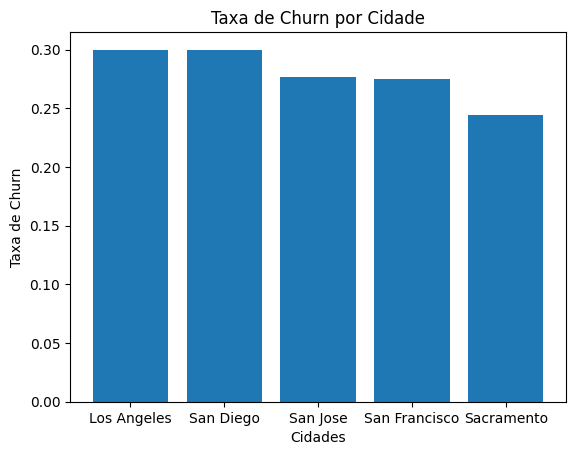

In [153]:
import matplotlib.pyplot as plt

cities = list(churn_rates.index)  # Nomes das cidades
values = list(churn_rates.values)  # Taxas de churn

plt.bar(cities, values)

plt.xlabel('Cidades')
plt.ylabel('Taxa de Churn')
plt.title('Taxa de Churn por Cidade')

plt.show()

### 1.2 O churn é mais prevalente entre clientes recentes ou antigos? Quais serviços são menos utilizados?

Análise tenure x churn

O que é possível identificar nessa análise?

1. Algumas colunas tem apenas um valor possível (Count,Country,State)



In [154]:
# Checar quantas colunas tem apenas um valor

def count_single_value_columns(df):
    single_value_columns = [col for col in df.columns if df[col].nunique() == 1]
    return len(single_value_columns), single_value_columns

single_value_columns = count_single_value_columns(train_df)

print(single_value_columns)


(3, ['Count', 'Country', 'State'])


In [155]:
dropped_train = train_df.drop(single_value_columns[1],axis=1)
dropped_test = test_df.drop(single_value_columns[1],axis=1)

In [156]:
dropped_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         5986 non-null   object 
 1   City               5986 non-null   object 
 2   Zip Code           5986 non-null   int64  
 3   Lat Long           5986 non-null   object 
 4   Latitude           5986 non-null   float64
 5   Longitude          5986 non-null   object 
 6   Gender             5986 non-null   object 
 7   Senior Citizen     5986 non-null   int64  
 8   Partner            5986 non-null   int64  
 9   Dependents         5986 non-null   int64  
 10  Tenure Months      5986 non-null   int64  
 11  Phone Service      5986 non-null   int64  
 12  Multiple Lines     5986 non-null   object 
 13  Internet Service   5986 non-null   object 
 14  Online Security    5986 non-null   object 
 15  Online Backup      5986 non-null   object 
 16  Device Protection  5986 

A coluna Lat Long ja é divida e representada pelas colunas latitude e longitude e também pode ser eliminada

In [157]:
dropped_train = dropped_train.drop('Lat Long',axis=1)
dropped_test = dropped_test.drop('Lat Long',axis=1)

In [158]:
dropped_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         5986 non-null   object 
 1   City               5986 non-null   object 
 2   Zip Code           5986 non-null   int64  
 3   Latitude           5986 non-null   float64
 4   Longitude          5986 non-null   object 
 5   Gender             5986 non-null   object 
 6   Senior Citizen     5986 non-null   int64  
 7   Partner            5986 non-null   int64  
 8   Dependents         5986 non-null   int64  
 9   Tenure Months      5986 non-null   int64  
 10  Phone Service      5986 non-null   int64  
 11  Multiple Lines     5986 non-null   object 
 12  Internet Service   5986 non-null   object 
 13  Online Security    5986 non-null   object 
 14  Online Backup      5986 non-null   object 
 15  Device Protection  5986 non-null   object 
 16  Tech Support       5986 